In [152]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy.stats
from scipy.stats import entropy
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

In [77]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import get_variance, get_distinctness_from_nearest_5
from utils.utils_funcs import load_data_to_dict

In [78]:
# aggregate both visual embeddings and language embeddings
def aggregate_embeddings_visual_and_language(input_struct,n_sample_per_visual,n_sample_per_language):
	words=input_struct['words']
	embed_dict=dict()
	for word in words:
		n_sample_v = min(len(input_struct['embeds'][word]['visual']), n_sample_per_visual)
		visual_temp=np.mean(np.array(random.sample(input_struct['embeds'][word]['visual'],n_sample_v)),axis=0)
		n_sample_l = min(len(input_struct['embeds'][word]['language']), n_sample_per_language)
		language_temp=np.mean(np.array(random.sample(input_struct['embeds'][word]['language'],n_sample_l)),axis=0)
		#embed_dict[word]=dict(visual=np.expand_dims(visual_temp,axis=0),language=language_temp)
		embed_dict[word]=dict(visual=visual_temp,language=np.squeeze(language_temp))
	return dict(embeds=embed_dict,words=words)

In [79]:
def get_concept_level_alignment_strength(struct,concepts,targets):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    sim_z_0=cosine_similarity(z_0)
    sim_z_1=cosine_similarity(z_1)
    rt=list()
    for target in targets:
        idx=concepts.index(target)
        rt.append(spearmanr(sim_z_0[idx],sim_z_1[idx])[0])
    return rt

In [80]:
def get_variance(struct):
    words=struct["words"]
    visual_variance=dict()
    language_variance=dict()
    for word in words:
        visual_embeddings=struct["embeds"][word]["visual"]
        visual_variance[word]=np.mean(np.linalg.norm(visual_embeddings-np.mean(visual_embeddings,axis=0),axis=1))
        language_embeddings=struct["embeds"][word]["language"]
        language_variance[word]=np.mean(np.linalg.norm(language_embeddings-np.mean(language_embeddings,axis=0),axis=1))
    return visual_variance,language_variance

In [81]:
def get_distinctness_from_nearest_5(struct):
    words=struct["words"]
    visual_centers=dict()
    language_centers=dict()
    for word in words:
        visual_embeddings=np.array(struct["embeds"][word]["visual"])
        visual_centers[word]=np.mean(visual_embeddings,axis=0)
        language_embeddings=np.array(struct["embeds"][word]["language"])
        language_centers[word]=np.mean(language_embeddings,axis=0)
    visual_distinctness=dict()
    language_distinctness=dict()
    for word in words:
        visual_distances=[np.linalg.norm(visual_centers[word]-visual_centers[temp]) for temp in words]
        visual_distinctness[word]=np.sum(sorted(visual_distances)[:6])/5
        language_distances=[np.linalg.norm(language_centers[word]-language_centers[temp]) for temp in words]
        language_distinctness[word]=np.sum(sorted(language_distances)[:6])/5
    return visual_distinctness,language_distinctness

In [82]:
def combine_all_data(data,aoa_dict,v_var_dict,l_var_dict,v_dist_dict,l_dist_dict):
    aoas=list()
    v_vars=list()
    l_vars=list()
    v_dists=list()
    l_dists=list()
    
    intersect_concepts=list()
    for concept in aoa_dict:
        if concept in data['words']:
            aoas.append(aoa_dict[concept])
            v_vars.append(v_var_dict[concept])
            l_vars.append(l_var_dict[concept])
            v_dists.append(v_dist_dict[concept])
            l_dists.append(l_dist_dict[concept])
            intersect_concepts.append(concept)
    alignments=get_concept_level_alignment_strength(data,data['words'],intersect_concepts)
    return aoas,alignments,v_vars,l_vars,v_dists,l_dists

In [83]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_swav_bert_window5_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_swav_bert_window5_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [84]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_ll_swav_bert_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_ll_swav_bert_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [130]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_bert_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_bert_20.pkl","rb"))

aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [131]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_glove_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_glove_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,1)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,1)

----

In [132]:
noun_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_noun_aoa.txt",concepts=vg_noun_data["words"])
verb_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_verb_aoa.txt",concepts=vg_verb_data["words"])

noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [133]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [134]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

----

In [135]:
noun_visual_variance,noun_language_variance=get_variance(vg_noun_data)
verb_visual_variance,verb_language_variance=get_variance(vg_verb_data)

In [136]:
noun_visual_distinctness,noun_language_distinctness=get_distinctness_from_nearest_5(vg_noun_data)
verb_visual_distinctness,verb_language_distinctness=get_distinctness_from_nearest_5(vg_verb_data)

----

In [137]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists=combine_all_data(aggregated_vg_noun_data,noun_aoa_dict,
                                                              noun_visual_variance,noun_language_variance,
                                                              noun_visual_distinctness,noun_language_distinctness)

In [138]:
df1=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists])),columns=['aoa','alignment','v_variance','l_variance','v_distinctness','l_distinctness'])
df1['type']='noun'

In [139]:
df1

,aoa,alignment,v_variance,l_variance,v_distinctness,l_distinctness,type
0,3.94,0.139615,0.852245,50.703705,0.447111,42.376260,noun
1,3.94,0.150224,0.551016,40.756992,0.650410,44.606613,noun
2,2.89,0.235282,0.874247,41.791233,0.419463,42.262488,noun
3,4.15,0.165673,0.748129,46.475052,0.410796,46.610046,noun
4,3.26,0.315951,0.732328,50.418419,0.295403,40.250897,noun
...,...,...,...,...,...,...,...
202,4.58,0.041340,0.933856,46.744148,0.362304,46.396503,noun
203,4.42,0.311120,0.798456,42.880585,0.323192,55.662915,noun
204,5.94,0.355143,0.579740,42.371300,0.265411,44.330948,noun
205,4.77,0.116776,0.764906,47.698044,0.317469,46.484955,noun


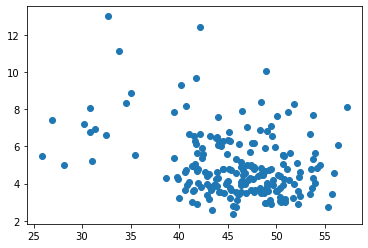

In [140]:
plt.scatter(df1['l_variance'],df1['aoa'])

In [141]:
X = np.column_stack((df1['alignment'], df1['v_variance'], df1['l_variance'], df1['v_distinctness'], df1['l_distinctness']))
y= df1['aoa']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    aoa   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     7.476
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.86e-06
Time:                        09:56:21   Log-Likelihood:                -390.50
No. Observations:                 207   AIC:                             793.0
Df Residuals:                     201   BIC:                             813.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0554      2.689      1.508      0.1

###### np.corrcoef(aoas,alignments)

In [142]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists=combine_all_data(aggregated_vg_verb_data,verb_aoa_dict,
                                                              verb_visual_variance,verb_language_variance,
                                                              verb_visual_distinctness,verb_language_distinctness)

In [143]:
df2=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists])),columns=['aoa','alignment','v_variance','l_variance','v_distinctness','l_distinctness'])
df2['type']='verb'

In [144]:
df2

,aoa,alignment,v_variance,l_variance,v_distinctness,l_distinctness,type
0,13.36,0.072616,0.840220,31.420040,0.463396,45.318704,verb
1,8.53,0.123126,0.882576,45.573303,0.310096,40.727863,verb
2,5.10,0.196881,0.717110,50.922478,0.627011,40.677173,verb
3,8.43,0.133013,0.874547,40.139629,0.355228,44.596674,verb
4,9.63,0.172378,0.842431,29.418020,0.331684,50.469727,verb
...,...,...,...,...,...,...,...
202,4.63,0.142458,0.826620,50.904129,0.311756,40.874939,verb
203,7.11,0.034334,0.893986,36.325062,0.289481,39.528384,verb
204,5.86,0.163373,0.855670,50.715305,0.298471,40.862585,verb
205,4.89,0.047021,0.911343,47.170040,0.320508,42.110791,verb


In [ ]:
results = smf.ols(formula = 'aoa ~ v_variance + l_variance + v_distinctness +l_distinctness + type',data=df1).fit()
results.summary()

In [145]:
X = np.column_stack((df2['alignment'], df2['v_variance'], df2['l_variance'], df2['v_distinctness'], df2['l_distinctness']))
y= df2['aoa']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    aoa   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     11.73
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           5.87e-10
Time:                        09:56:24   Log-Likelihood:                -448.17
No. Observations:                 207   AIC:                             908.3
Df Residuals:                     201   BIC:                             928.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.6007      4.011      3.640      0.0

In [146]:
np.corrcoef(aoas,alignments)

array([[ 1.        , -0.08197382],
       [-0.08197382,  1.        ]])

In [149]:
df=pd.concat([df1,df2])

In [150]:
df

,aoa,alignment,v_variance,l_variance,v_distinctness,l_distinctness,type
0,3.94,0.139615,0.852245,50.703705,0.447111,42.376260,noun
1,3.94,0.150224,0.551016,40.756992,0.650410,44.606613,noun
2,2.89,0.235282,0.874247,41.791233,0.419463,42.262488,noun
3,4.15,0.165673,0.748129,46.475052,0.410796,46.610046,noun
4,3.26,0.315951,0.732328,50.418419,0.295403,40.250897,noun
...,...,...,...,...,...,...,...
202,4.63,0.142458,0.826620,50.904129,0.311756,40.874939,verb
203,7.11,0.034334,0.893986,36.325062,0.289481,39.528384,verb
204,5.86,0.163373,0.855670,50.715305,0.298471,40.862585,verb
205,4.89,0.047021,0.911343,47.170040,0.320508,42.110791,verb


In [ ]:
results = smf.ols(formula = 'aoa ~ v_variance + l_variance + v_distinctness +l_distinctness + type',data=df2).fit()
results.summary()

In [151]:
X = np.column_stack((df['alignment'], df['v_variance'], df['l_variance'], df['v_distinctness'], df['l_distinctness'], df['type']))
y= df['aoa']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [158]:
results = smf.ols(formula = 'aoa ~ v_variance + l_variance + v_distinctness +l_distinctness + type',data=df).fit()

In [159]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    aoa   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     26.83
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.83e-23
Time:                        10:01:37   Log-Likelihood:                -856.31
No. Observations:                 414   AIC:                             1725.
Df Residuals:                     408   BIC:                             1749.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.2397      2.116      4.840      0.000       6.080      14.399
type[T.verb]       1.5454      0.222      6.963      0.000       1.109       1.982
v_variance        -0.2077      1.175     -0.177      0.860      -2.517       2.101
l_variance        -0.1404      0.017     -8.067      0.000      -0.175      -0.106
v_distinctness    -0.8224      1.208     -0.681      0.496      -3.196       1.552
l_distinctness     0.0370      0.029      1.256      0.210      -0.021       0.095
==============================================================================
Omnibus:                       48.669   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.322
Skew:                           0.773   Prob(JB):                     1.20e-16
Kurtosis:                       4.363   Cond. No.                     1.57e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""